## MODELLING TANZANIA WATER POINTS

### Data pre-processing

I will drop some columns that have no meaningfull information to the model. I will also convert our target variable from strings of (functional, non functional, functional needs repair) to 0,1 and 2 values in order to make our model. I will import my cleaned data from my EDA notebook for the purpose of modelling. This will help in reducing run time for my modelling purpose. 

In [31]:
# importing necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer,RobustScaler
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

import category_encoders as ce
from category_encoders import WOEEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder, LeaveOneOutEncoder, JamesSteinEncoder, MEstimateEncoder

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import MinMaxScaler
from mlxtend.evaluate import feature_importance_permutation
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.svm import SVC
import gc; gc.enable()

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.preprocessing import MinMaxScaler

I will import the libraries to use for my modelling

Importing my EDA notebook

In [32]:
from ipynb.fs.full.EDA import *

In [33]:
df.head()

,gps_height,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,permit,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,status_group,construction_year_bins
0,1390,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109,True,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional,"(1990, 2000]"
1,1399,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280,True,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,"(2000, 2010]"
2,686,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250,True,True,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,"(2000, 2010]"
3,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58,True,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,"(1980, 1990]"
4,0,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,281,True,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,"(1990, 2000]"


I will create a copy of the cleaned data df from the EDA notebook so as to maintain the cleaned data as it is.

In [34]:
#create a copy of the clean df
clean_df = df.copy()

In [35]:
clean_df.head()

,gps_height,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,permit,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,status_group,construction_year_bins
0,1390,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109,True,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional,"(1990, 2000]"
1,1399,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280,True,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,"(2000, 2010]"
2,686,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250,True,True,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,"(2000, 2010]"
3,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58,True,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,"(1980, 1990]"
4,0,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,281,True,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,"(1990, 2000]"


#### Converting Target variable to numerical variables of 0,1,2

We need to convert our target variable from strings of (functional, non functional, functional needs repair) to 0,1 and 2 values in order to make our model

In [36]:
target_variable = {'functional':0, 
                   'non functional': 2, 
                   'functional needs repair': 1} 
clean_df['status_group'] = clean_df['status_group'].replace(target_variable)

In [37]:
clean_df['status_group'].value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

- 0 = functional water points ,

- 2 = non-functinal water point

- 1 = functional but needs repair water points,



I will drop Iga and ward columns since we have region column with similar information

In [38]:
#drop Iga and ward columns since we have region column with similar information
clean_df.drop(columns=['lga','ward'],inplace=True ) 

#### converting boolean type column of true or false values to 0 and 1

In [39]:
#convert True/False in permit column to 0-1(boolean to int)
clean_df['permit'] =clean_df['permit'].astype(bool).astype(int) 

In [40]:
#convert True/False in public meeting column to 0-1(boolean to int)
clean_df['public_meeting'] = clean_df['public_meeting'].astype(bool).astype(int)

#### Dividing all the features in categorical and numerical features and give them variables

I will divide my features into two categories i.e `numerical_variables` to be scaled using scaler and `categorical_variables` to be  encoded using encoder

In [41]:
# numerical features placed in a variable 
numerical_variables = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit'] 

In [42]:
# categorical features placed in a variable  
categorical_variables = ['basin','region','extraction_type_group','management','payment','water_quality','quantity',
               'source','waterpoint_type','construction_year_bins']

### Converting Target Ternary classes to Target Binary classes

I will convert my target variable from having three classes to having two classes. I will combine functional water points with water points that are functional needs repair as 1. I will make non functional water points to be 0

In [43]:
# convert ternary classes to binary class
status_group_dict = {0:1, 1: 1, 2 : 0}
clean_df['status_group'] = clean_df['status_group'].replace(status_group_dict )

In [44]:
#print the status group value count
clean_df['status_group'].value_counts()

1    36576
0    22824
Name: status_group, dtype: int64

Now we have two categories to be predicted(binary)
- 1 = functional water points ,

- 0 = non-functinal water point




### Making Pipeline

Dividing the data into x(predictive_features) and y(target feature)

In [45]:
# create the target variable and the predictors in form of x and y
y = clean_df['status_group']
X = clean_df.drop('status_group', axis=1)



Dividing the data into training and testing data

In [46]:
# to divide our X and y to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Since categorical data is inform of string I will use target encoder to encode the categories into int by replacing them for a measurement of the effect they might have on the target.
I will standardize the numerical features using MinMaxScaler.
For this project i will use different scalers, encoders, and classification models with the pipeline. 

In [47]:
# Giving the robustScaler and TargetEncoder a variable.
scaler = RobustScaler()
encoder = ce.TargetEncoder(cols=categorical_variables)

The make_pipeline function will be automatically applied scaler, encoder, and our model to the pipe in order to fit it very easily.

In [48]:
# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

In [49]:
# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, numerical_variables),
                    ('cat', cat_transformer, categorical_variables)])


### MODEL 1: Logistic Regression

In [50]:
lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

In [51]:
# giving all values to pipeline
pipe = make_pipeline(preprocessor,lr)
pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

print("Accuracy:")
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:")
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

Accuracy:
TRAIN: 0.7640572390572391
TEST: 0.7692760942760942

Balanced Accuracy:
TRAIN: 0.7418625912097385
TEST: 0.7463425907968401


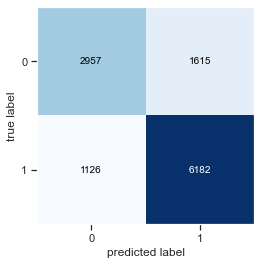

In [52]:
# to plot and understand confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

The confusion matrix above shows that 1126 water points were missclassified as non-functional water points instead of functional waterpoints. Also, 1615 water points were missclassified as functional water points instead of non-functional water points. 

#### Draw the ROC curve

implementing AUC and ROC via 

In [53]:
from sklearn.metrics import roc_curve, auc

# Scikit-learn's built in roc_curve method returns the fpr, tpr, and thresholds
# for various decision boundaries given the case member probabilites

# First calculate the probability scores of each of the datapoints:
y_score = pipe.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

calculating the AUC

In [54]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.8256004786997412


Creating an ROC curve for  predictions

AUC: 0.8256004786997412


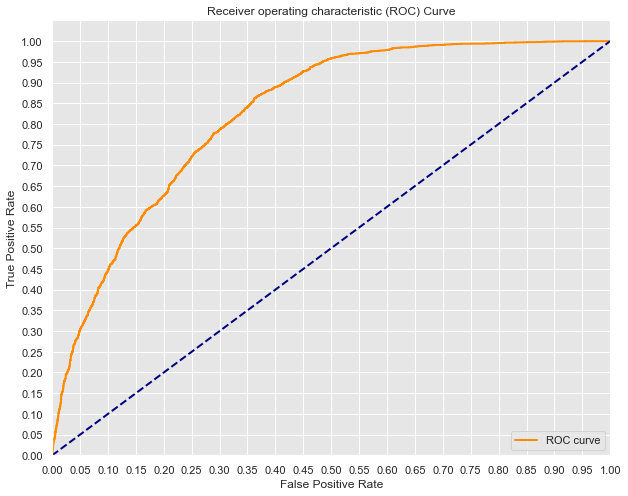

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()